# Benchmarking Results

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

### 1. Load, Summarize, Insert

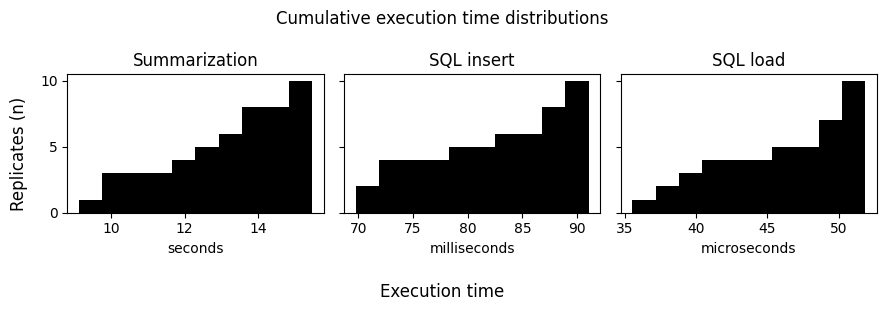

,replicate,num_abstracts,total_replicate_time,total_summarization_time,total_insert_time,total_loading_time,mean_total_time,mean_summarization_time,mean_insert_time,mean_loading_time
0,1,5,46.017187,45.617424,0.399505,0.000258,9.203437,9.123485,0.079901,0.000052
1,2,5,69.757739,69.402214,0.355265,0.000259,13.951548,13.880443,0.071053,0.000052
2,3,5,59.380586,58.939484,0.440871,0.000232,11.876117,11.787897,0.088174,0.000046
3,4,5,71.140245,70.719397,0.420602,0.000246,14.228049,14.143879,0.084120,0.000049
4,5,5,51.084247,50.722499,0.361550,0.000198,10.216849,10.144500,0.072310,0.000040


In [2]:
data = pd.read_csv('../benchmarks/load_summarize_insert/results.csv')

titles = ['Summarization', 'SQL insert', 'SQL load']
data_types = ['mean_summarization_time', 'mean_insert_time', 'mean_loading_time']
xlabels = ['seconds', 'milliseconds', 'microseconds']
xaxis_scales = [1, 10**3, 10**6]

fig, axs = plt.subplots(1, 3, figsize=(9, 3), sharey=True, tight_layout=True)

fig.suptitle('Cumulative execution time distributions')
fig.supxlabel('Execution time')
fig.supylabel('Replicates (n)')

axs_num = 0

for title, data_type, xlabel, xaxis_scale in zip(titles, data_types, xlabels, xaxis_scales):

    axs[axs_num].set_title(title)
    axs[axs_num].set_xlabel(xlabel)
    axs[axs_num].xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
    axs[axs_num].hist(
        data[data_type] * xaxis_scale,
        histtype="stepfilled", 
        cumulative=1,
        color='black'
    )

    axs_num += 1

plt.show()

data.head()

### 2. Huggingface Device Map

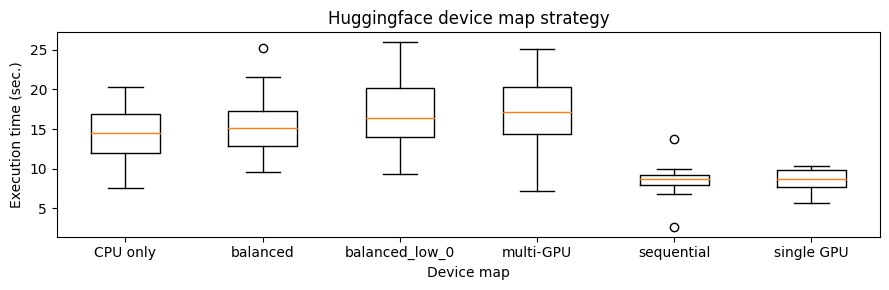

device_map_strategy,CPU only,balanced,balanced_low_0,multi-GPU,sequential,single GPU
abstract_num,,,,,,
1,14.629446,14.325428,14.644230,13.601670,9.115461,5.729851
2,16.952201,25.291227,17.797969,25.049128,8.137315,9.881240
3,10.698561,16.870332,20.193103,12.690567,8.680656,10.356685
4,13.310327,11.688495,19.142370,15.408093,6.754567,7.875445
5,14.418210,9.565301,24.330230,16.649144,9.998038,9.669265


In [3]:
data = pd.read_csv('../benchmarks/huggingface_device_map/results.csv')
data = data.pivot(index='abstract_num', columns='device_map_strategy', values='summarization_time')

fig, axs = plt.subplots(1, 1, figsize=(9, 3), tight_layout=True)

axs.set_title('Huggingface device map strategy')
axs.set_xlabel('Device map')
axs.set_ylabel('Execution time (sec.)')
axs.boxplot(data, labels=data.columns)

plt.show()

data.head()

### 3. Parallel Summarization

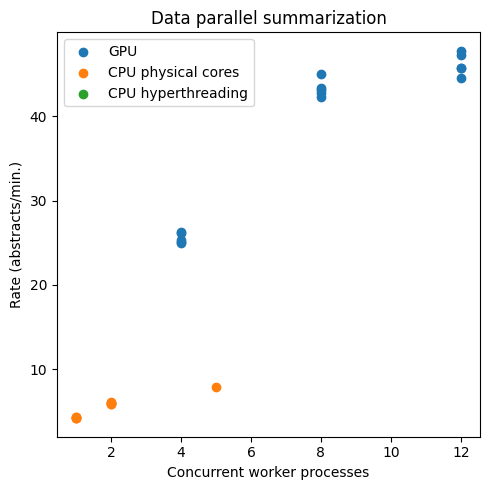

,replicate,abstracts,abstracts per worker,workers,device map strategy,summarization time (sec.),summarization rate (abstracts/sec.)
0,0,120,30,4,GPU,273.865707,0.438171
1,1,120,30,4,GPU,275.386583,0.435751
2,2,120,30,4,GPU,288.074333,0.416559
3,3,120,30,4,GPU,284.379060,0.421972
4,4,120,30,4,GPU,287.049007,0.418047


In [17]:
data = pd.read_csv('../benchmarks/parallel_summarize/results.csv')

device_map_strategies = ['GPU', 'CPU physical cores', 'CPU hyperthreading']

fig, axs = plt.subplots(1, 1, figsize=(5, 5), tight_layout=True)

axs.set_title('Data parallel summarization')
axs.set_xlabel('Concurrent worker processes')
axs.set_ylabel('Rate (abstracts/min.)')
axs.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))

for device_map_strategy in device_map_strategies:

    plot_data = data[data['device map strategy'] == device_map_strategy]
    axs.scatter(plot_data['workers'], plot_data['summarization rate (abstracts/sec.)'] * 60, label=device_map_strategy)

plt.legend(loc='upper left')
plt.show()

data.head()

### 4. SQL Insert

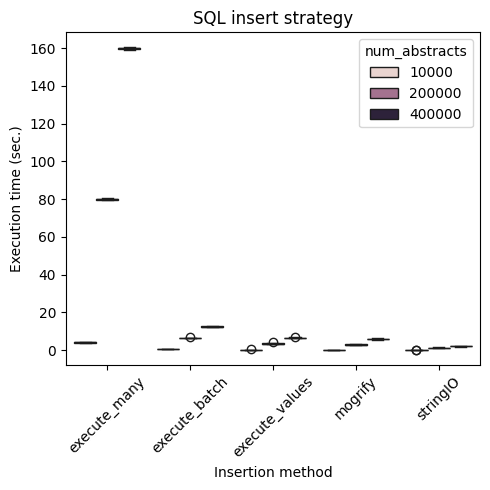

,num_abstracts,insert_time,insert_strategy,replicate
0,10000,4.258317,execute_many,1
1,10000,4.022138,execute_many,2
2,10000,4.073744,execute_many,3
3,10000,4.109033,execute_many,4
4,10000,4.187685,execute_many,5


In [5]:
data = pd.read_csv('../benchmarks/sql_insert/results.csv')
fig, axs = plt.subplots(1, 1, figsize=(5, 5), tight_layout=True)

axs.set_title('SQL insert strategy')
axs.set_ylabel('Execution time (sec.)')
axs.set_xlabel('Insertion method')
axs.tick_params(axis='x', labelrotation=45)

sns.boxplot(
    data=data, 
    x='insert_strategy',
    y='insert_time',
    hue='num_abstracts',
    ax=axs
)

plt.show()

data.head()